# LSTM model

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Loading data

In [3]:
from data_getter import *

30220 summaries containing 'No summary available'
6142 summaries containing 'Full story available on'
Duplicate summaries removed: 14242
Duplicate headlines removed: 404
randomizing order of data


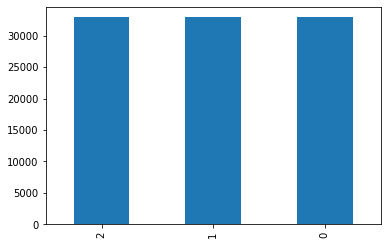

In [4]:
import matplotlib.pyplot as plt
balanced_dataset['priceChangeClass'].value_counts().plot(kind='bar');

## LSTM model

In [5]:
max_features = 100000  # Maximum vocab size.
max_len = 256 # Sequence length to pad the outputs to.
embedding_dims = 2

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_features, output_sequence_length=max_len)

encoder.adapt(test_data.summary.to_numpy())

In [6]:
vocab = np.array(encoder.get_vocabulary())
vocab.shape

(53962,)

In [7]:
train_data

,datetime,headline,summary,related,lang,source,1stepChange,2stepChange,3stepChange,priceChangeClass,6stepChange
0,2020-10-21 10:11:13-05:00,Q4 2020 EPS Estimates for Portland General Ele...,Portland General Electric (NYSE:POR) – KeyCorp...,POR,en,Transcript Daily,1.004938,1.008186,1.007406,1,1.015333
1,2019-09-27 02:31:11-05:00,Tata Motors tumbles 4 per cent on reports of J...,The stock tumbled over 4 per cent to Rs 119.30...,TTM,en,The Economic Times India,0.986127,0.986127,0.995376,0,0.996532
2,2020-01-23 05:20:00-05:00,Billionaire businessman Leslie Wexner refuses ...,"Leslie Wexner is the CEO of L Brands, which in...",LB,en,ABC News,1.002445,1.007335,1.015159,1,1.019560
3,2020-11-19 09:15:00-05:00,Condor Hospitality Announces Modification to I...,"NORFOLK, Neb.--(BUSINESS WIRE)---- $CDOR #Hote...",BMO,en,Business Wire,1.008436,1.003431,1.004289,1,1.001859
4,2020-05-16 11:09:52-05:00,Scott Disick’s style essentials are as luxe an...,From Louis Vuitton luggage to a watch that pro...,MC,en,Page Six,1.043058,1.036380,1.039016,2,1.044288
...,...,...,...,...,...,...,...,...,...,...,...
71059,2020-09-05 03:00:37-05:00,"Defi Boom Fueling ETH Gas Fees, Threatens Viab...","Growing Ethereum network transaction fees, whi...",ETH,en,Bitcoin.com News,1.015162,1.003790,0.987939,2,1.004824
71060,2020-06-12 10:00:31-05:00,BAE to produce more Vertical Launching System ...,BAE Systems will produce multiple types of Ver...,BA,en,UK Defence Journal,0.986078,0.947778,0.954360,0,0.978162
71061,2019-12-05 08:00:00-05:00,TE's new thermal bridge solution significantly...,"HARRISBURG, Pa., Dec. 5, 2019 /PRNewswire/ -- ...",TEL,en,PR Newswire,1.010157,1.006809,1.006586,2,1.009934
71062,2020-03-19 08:45:00-05:00,"Coronavirus Rampage Continues For Skechers, Gu...",Skechers (SKX) shuts company-owned retail stor...,SKX,en,Zacks Investment Research,0.920465,0.922326,0.980465,0,0.989191


In [8]:
example = ['DUBLIN , May 26, 2020 /PRNewswire/ -- The "Commercial Vehicle & Off-highway Radar - Global Market Outlook (2018-2027)" report has been added to ResearchAndMarkets.com\'s offering. The Global Commercial Vehicle & Off-highway Radar market accounted for $94.37 million in 2018 and is expected to reach $723.61 million by 2027, growing at a CAGR of 25.4% during the forecast period. Some of the key factors propelling the market growth are increasing number of autonomous vehicles, rising demand for commercial vehicles, and need for measuring the velocity of vehicles with high accuracy. However, inability of the system to distinguish multiple targets is the restraining factor for the growth of the market. By vehicle type, commercial vehicle segment is expected to grow at a significant market share during the forecast period as it is becoming necessary to tackle speed, distance, and such parameters of the commercial vehicles. On the basis of geography, Asia Pacific is anticipated to hold considerable market share during the forecast period due to the increasing infrastructure projects initiated by governments in the region']
encoded_example = encoder(example).numpy()
encoded_example
for n in range(1):
  print("Original: ", example[n])
  print("")
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  DUBLIN , May 26, 2020 /PRNewswire/ -- The "Commercial Vehicle & Off-highway Radar - Global Market Outlook (2018-2027)" report has been added to ResearchAndMarkets.com's offering. The Global Commercial Vehicle & Off-highway Radar market accounted for $94.37 million in 2018 and is expected to reach $723.61 million by 2027, growing at a CAGR of 25.4% during the forecast period. Some of the key factors propelling the market growth are increasing number of autonomous vehicles, rising demand for commercial vehicles, and need for measuring the velocity of vehicles with high accuracy. However, inability of the system to distinguish multiple targets is the restraining factor for the growth of the market. By vehicle type, commercial vehicle segment is expected to grow at a significant market share during the forecast period as it is becoming necessary to tackle speed, distance, and such parameters of the commercial vehicles. On the basis of geography, Asia Pacific is anticipated to ho

In [9]:
 #encoder(example)

In [20]:
num_classes = len(set(train_data.priceChangeClass))
print(f"Amount of classes: {num_classes}")
"""
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)#, activation='softmax')
])
"""

# Gave around 41-43% acc
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(rate=0.1),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)#, activation='softmax')
])

"""
# 42% after 1 epoch
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
"""

Amount of classes: 3


"\n# 42% after 1 epoch\nmodel = tf.keras.Sequential([\n    encoder,\n    tf.keras.layers.Embedding(\n        input_dim=len(encoder.get_vocabulary()),\n        output_dim=64,\n        # Use masking to handle the variable sequence lengths\n        mask_zero=True),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),\n    tf.keras.layers.Dense(64, activation='relu'),\n    tf.keras.layers.Dense(3, activation='softmax')\n])\n"

In [21]:
print([layer.supports_masking for layer in model.layers])
sample_text = ('The Global Commercial Vehicle & Off-highway Radar market accounted for $94.37 million in 2018 and is expected to reach $723.61 million by 2027, growing at a CAGR of 25.4% during the forecast period. Some of the key factors propelling the market growth are increasing number of autonomous vehicles, rising demand for commercial vehicles, and need for measuring the velocity of vehicles with high accuracy. However, inability of the system to distinguish multiple targets is the restraining factor for the growth of the market.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[False, True, True, True, True, True]
[-0.00301948  0.00237734 -0.00260312]


In [22]:
from sklearn.metrics import f1_score,classification_report
from data_analyser import calc_rate_of_return


test_x = np.array(test_data.summary)
test_y = np.array(test_data.priceChangeClass).astype(np.int8)

class EpochEndSummaryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("\nEvaluating")
        pred = model.predict(test_x)
        rez = []
        for elem in pred:
            aa = tf.math.argmax(elem)
            rez.append(aa.numpy())
            
        print(classification_report(test_data.priceChangeClass, rez, digits=3))
        
        rate_return = calc_rate_of_return(rez, test_data["1stepChange"].tolist(), buy_class=2)
        print(np.mean(rate_return))
        #print("End epoch {} of training; got log keys: {}".format(epoch, keys))


In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32))

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(val_x, val_y),
    epochs=15,
    callbacks=[EpochEndSummaryCallback()]
)

Epoch 1/15
2221/2221 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.4015
Evaluating
              precision    recall  f1-score   support

           0      0.381     0.613     0.470      5914
           1      0.492     0.393     0.437      5917
           2      0.415     0.246     0.309      5935

    accuracy                          0.417     17766
   macro avg      0.429     0.417     0.405     17766
weighted avg      0.429     0.417     0.405     17766

1.0032683263291649
2221/2221 [==============================] - 265s 119ms/step - loss: 1.0753 - accuracy: 0.4015 - val_loss: 1.0635 - val_accuracy: 0.4276
Epoch 2/15
2221/2221 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.5083
Evaluating
              precision    recall  f1-score   support

           0      0.428     0.383     0.404      5914
           1      0.470     0.494     0.482      5917
           2      0.412     0.433     0.422      5935

    accuracy               

In [54]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


309/309 [==============================] - 6s 20ms/step - loss: 1.5031 - accuracy: 0.4227
Test Loss: 1.5031203031539917
Test Accuracy: 0.4226950407028198


In [55]:
#del calc_rate_of_return
from data_analyser import calc_rate_of_return

In [56]:
pred = model.predict(np.array(test_data.summary))

In [57]:
pred

array([[ 0.00279048, -0.22590958,  0.14025693],
       [-0.61930984, -0.463526  ,  0.8515767 ],
       [-0.49931228, -1.3707545 ,  1.1062266 ],
       ...,
       [ 0.9530206 , -0.7097001 , -0.5737804 ],
       [-0.6955192 ,  1.411898  , -0.16117309],
       [-0.01177319,  0.68542564, -0.44795248]], dtype=float32)

In [58]:
pred_classes = tf.math.argmax(pred, axis=1).numpy()
print(pred_classes)

[2 2 2 ... 0 1 1]


In [59]:
pred_classes[0] == 1

False

In [60]:
sum(pred_classes[i] == test_data.iloc[i].priceChangeClass for i in range(len(pred_classes))) / len(pred_classes)

0.41573792637622425

In [61]:
rate_return = calc_rate_of_return(pred_classes, test_data["1stepChange"].tolist(), buy_class=2)

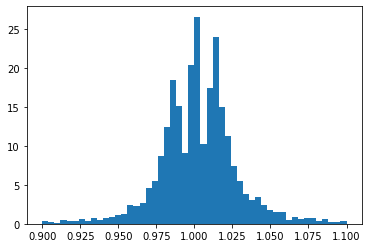

In [62]:
plot = plt.hist(rate_return, bins=50, density=True, range=[0.9,1.1])

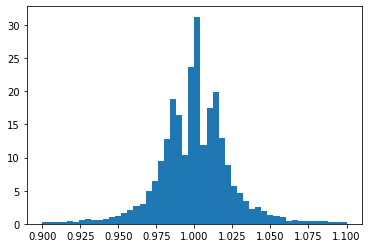

In [63]:
plot = plt.hist(test_data["1stepChange"].tolist(), bins=50, density=True, range=[0.9,1.1])

In [64]:
np.mean(rate_return)

1.0026595887120615

In [65]:
np.mean(test_data["1stepChange"].tolist())

1.0001833401770026

In [31]:
model.save(f"models/LSTM/{test_acc:.5f}_acc")

(0.0, 1.1201188877224921)

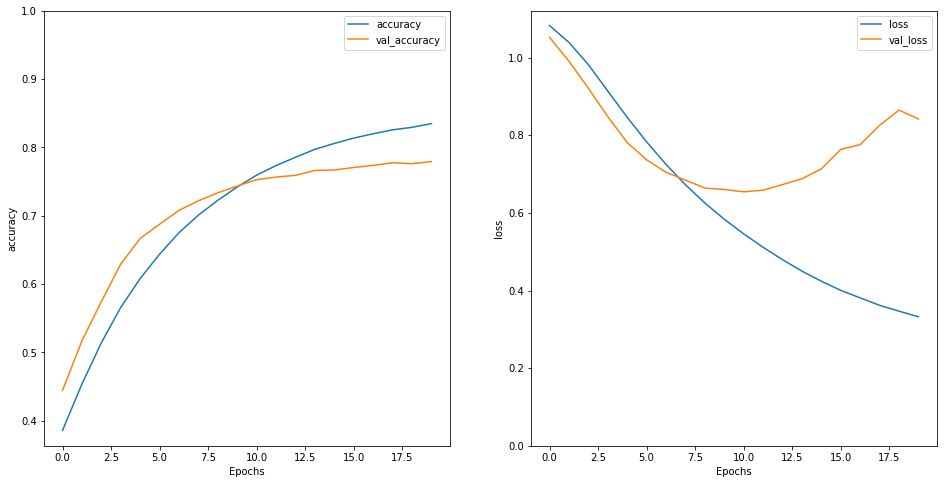

In [32]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [34]:
pred = model.predict(test_x)
rez = []
for elem in pred:
    aa = tf.math.argmax(elem)
    rez.append(aa.numpy())
np.count_nonzero(rez == test_y) / len(rez)

0.7777465508431273

In [35]:
tf.math.confusion_matrix(labels=test_y, predictions=rez)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 9592,  2194,  1195],
       [ 1007, 10755,  1132],
       [ 1036,  2135, 10094]], dtype=int32)>